In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
adata = sc.read_h5ad('dataset/Karthaus/karthaus.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 120300 × 33538
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum'
    var: 'ID', 'Symbol'

In [3]:
# data is already normalised to log2 (transcripts per 10K + 1) but i should try to be somewhat consistent
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

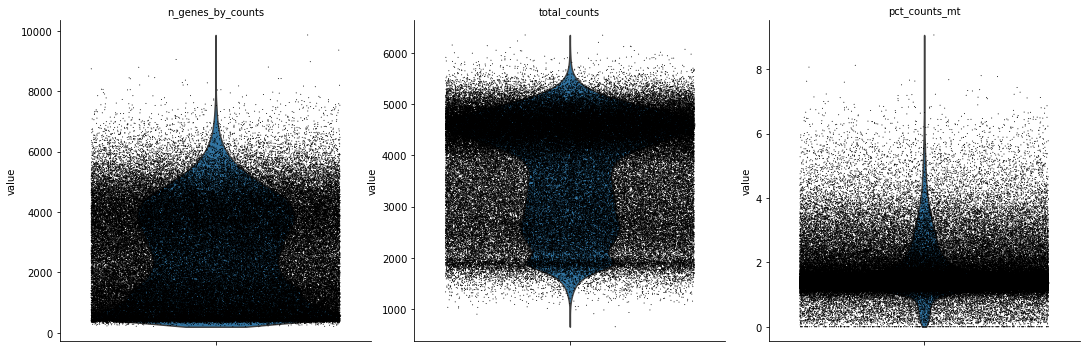

In [4]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


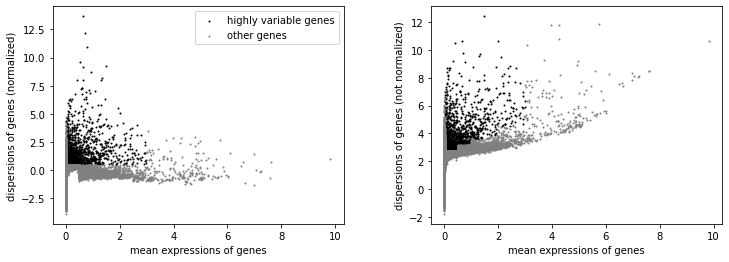

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
adata.raw = adata

In [8]:
adata = adata[:, adata.var.highly_variable]

In [9]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:03:38)


In [10]:
sc.pp.scale(adata, max_value=10)

In [11]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


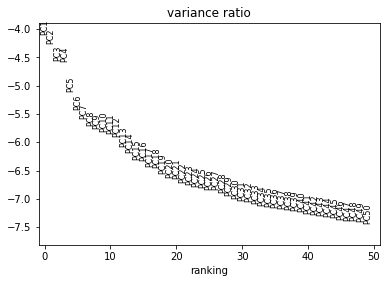

In [12]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [13]:
import bbknn

In [14]:
# sc.external.pp.bbknn not updated yet
bbknn.bbknn(adata, batch_key='PatientNum')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:25)


In [15]:
sc.tl.umap(adata, min_dist = 0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:31)


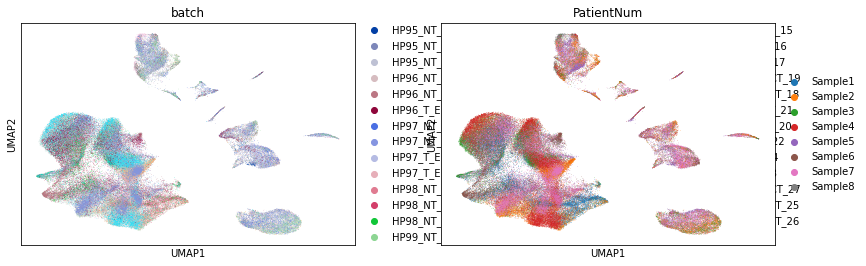

In [16]:
sc.pl.umap(adata, color = ['batch', 'PatientNum'])

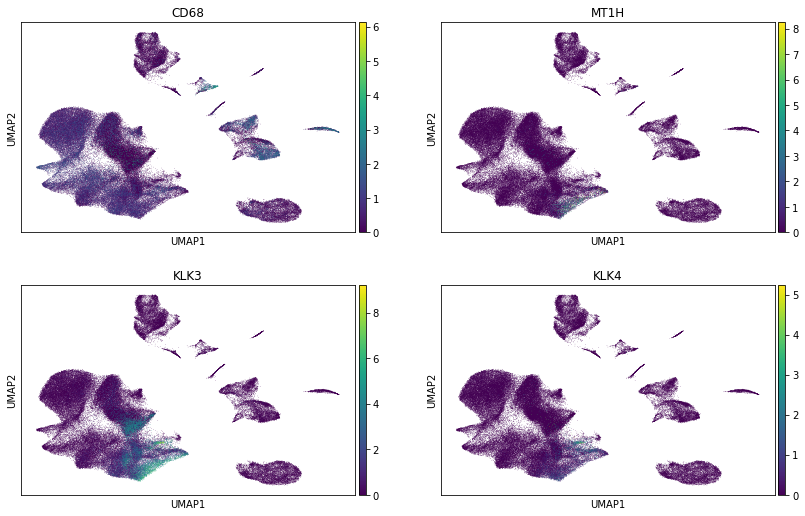

In [17]:
sc.pl.umap(adata, color = ['CD68', 'MT1H', 'KLK3', 'KLK4'], ncols =2)

In [18]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:05)


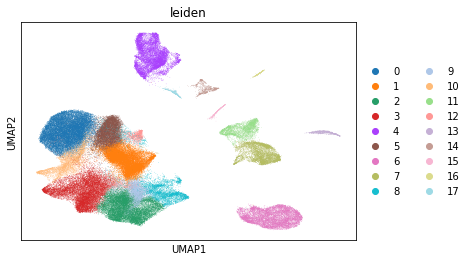

In [19]:
sc.pl.umap(adata, color = 'leiden')

In [20]:
adata.write_h5ad('dataset/Karthaus/karthaus_processed.h5ad', compression = 'gzip')